# 一、使用LSTM进行回归

开始查询数据...


100%|██████████| 34/34 [00:22<00:00,  1.50it/s]


date     open    close     high      low       amount
0     1990-12-19    96.05    99.98    99.98    95.79       1260.0
1     1990-12-20   104.30   104.39   104.39    99.98        197.0
2     1990-12-21   109.07   109.13   109.13   103.73         28.0
3     1990-12-24   113.57   114.55   114.55   109.13         32.0
4     1990-12-25   120.09   120.25   120.25   114.55         15.0
...          ...      ...      ...      ...      ...          ...
7817  2022-12-30  3084.52  3089.26  3096.31  3082.20  217545344.0
7818  2023-01-03  3087.51  3116.51  3119.86  3073.05  281370362.0
7819  2023-01-04  3117.57  3123.52  3129.09  3109.45  273313626.0
7820  2023-01-05  3132.76  3155.22  3159.43  3130.23  257003018.0
7821  2023-01-06  3155.07  3157.64  3170.74  3151.84  257380255.0

[7822 rows x 6 columns]

开始分析....


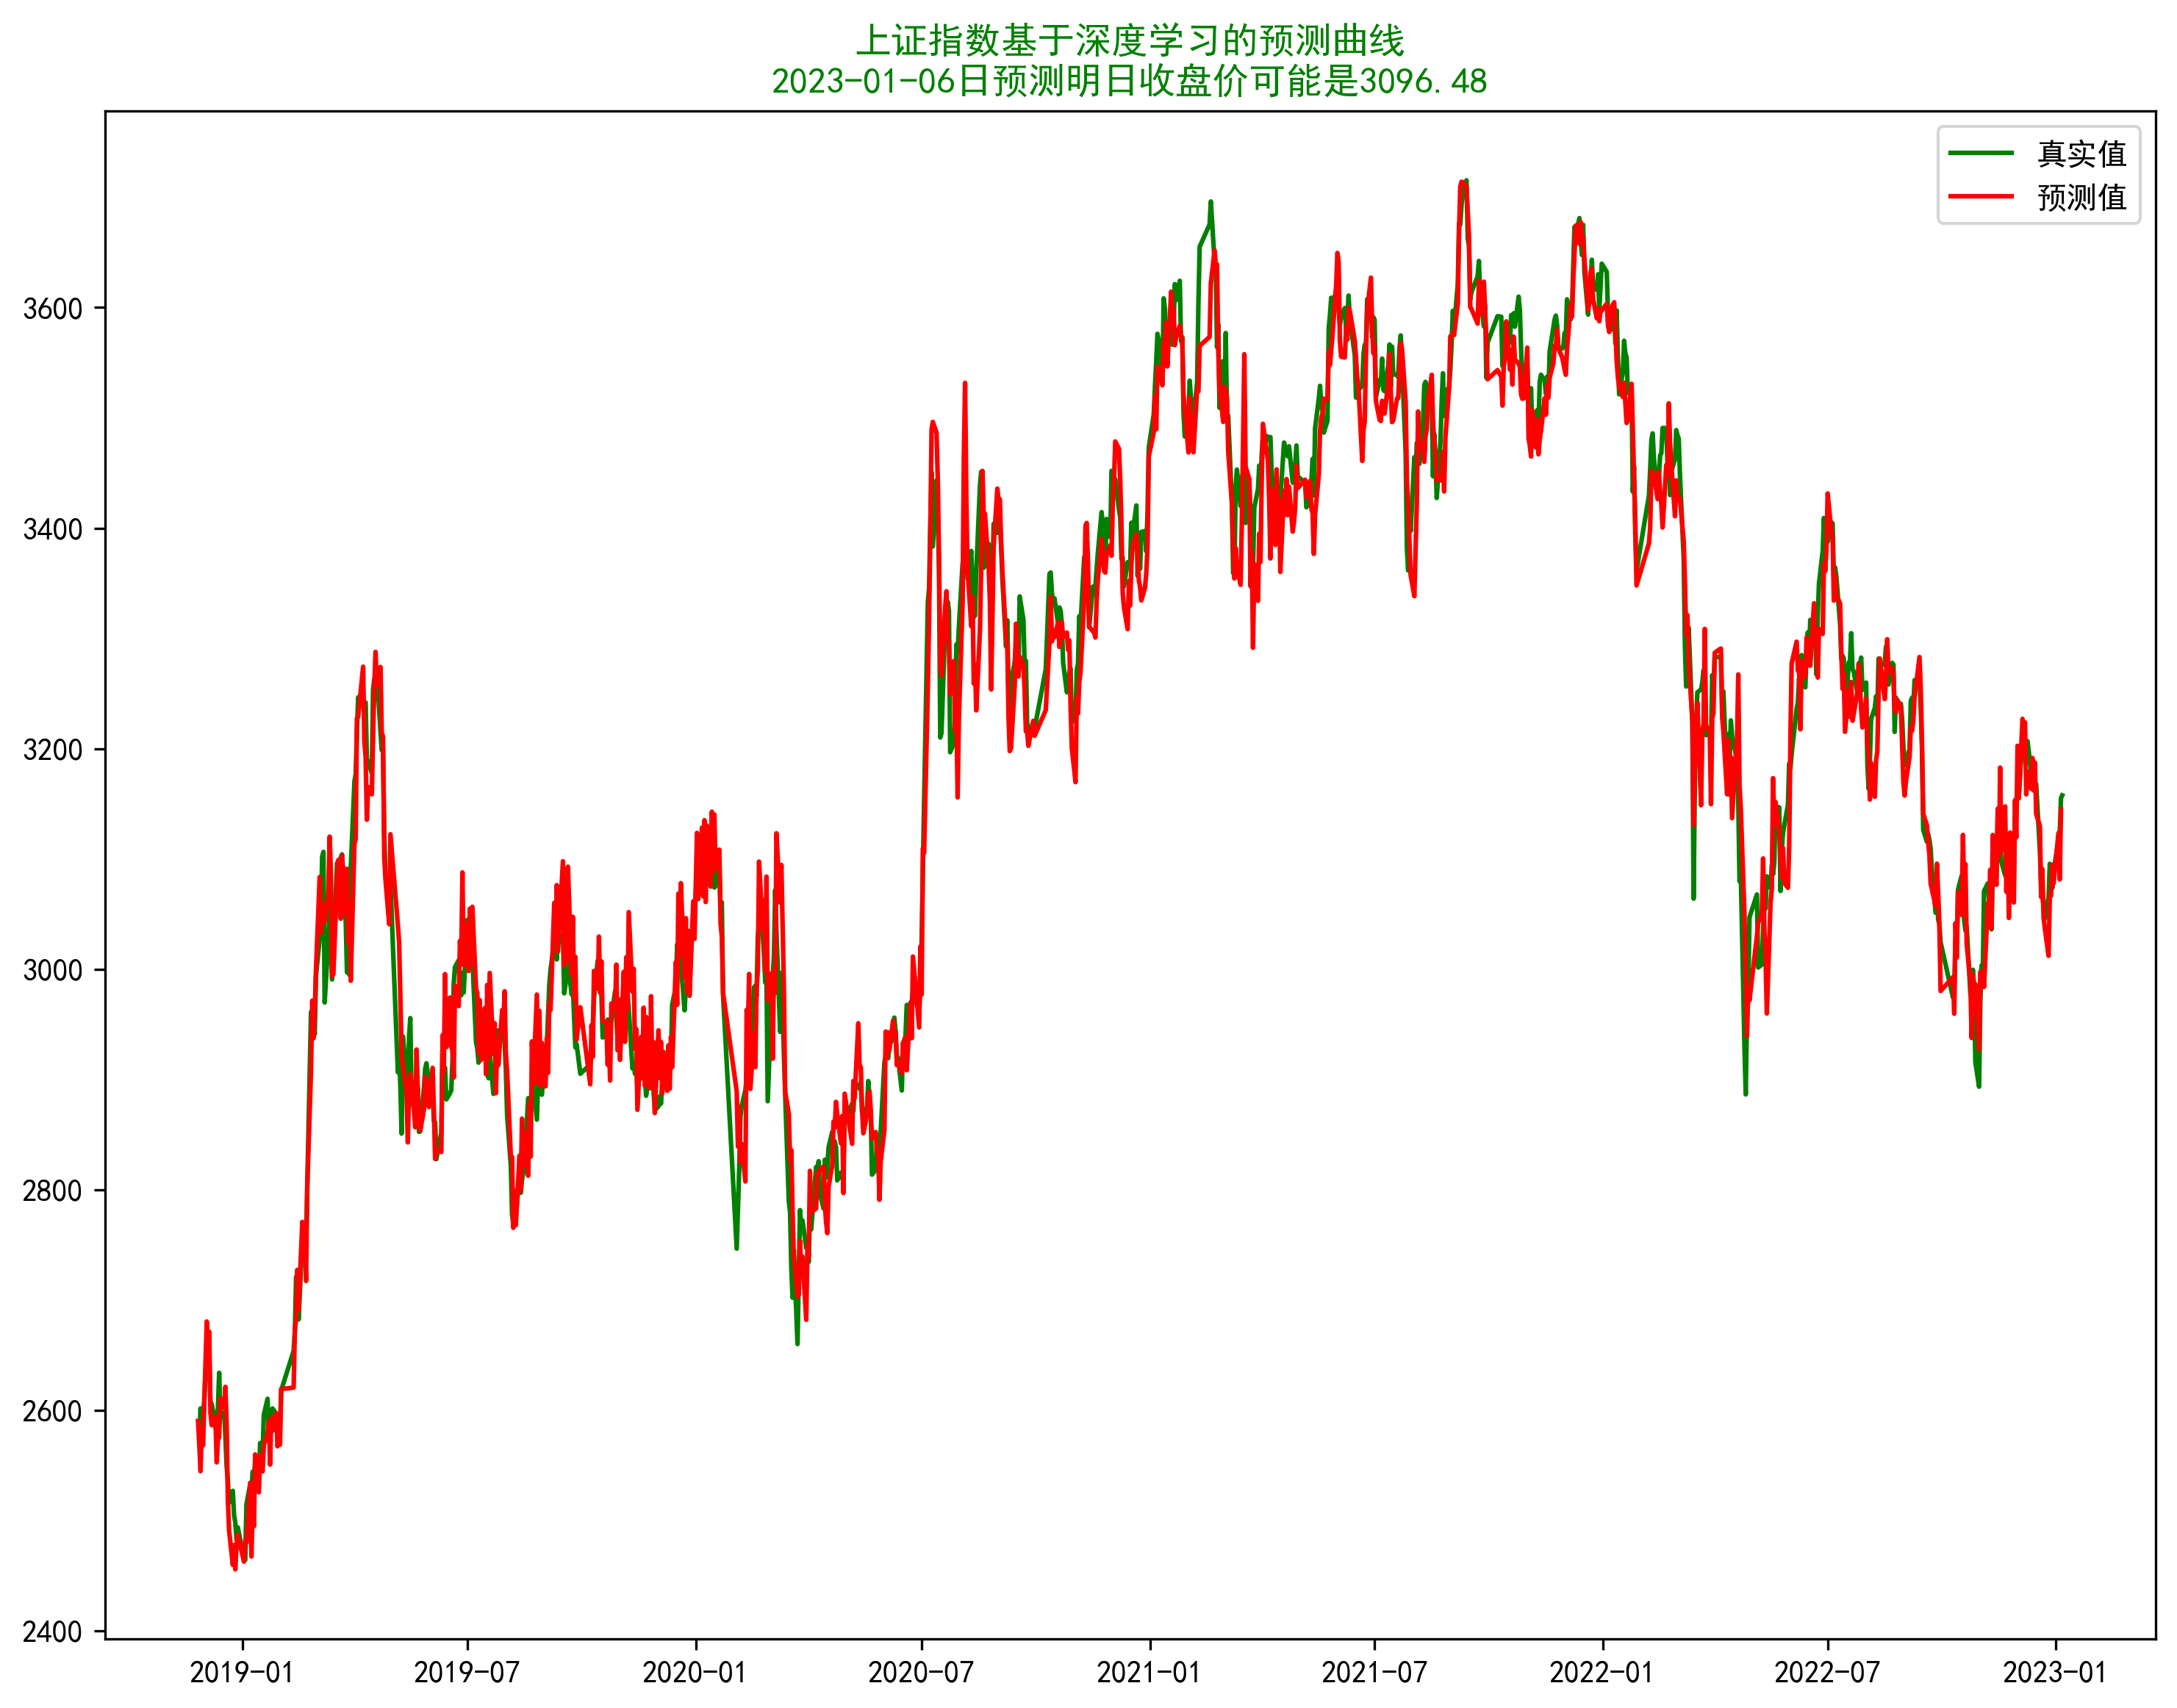

date          pre         real   preRise  realRise  isRight
0   2022-11-17  2916.531696  3115.430000  0.000000  0.000000        0
1   2022-11-18  3106.930931  3097.240000 -0.063843 -0.005839        1
2   2022-11-21  3147.569166  3085.040000  0.003129 -0.003939        0
3   2022-11-22  3070.185199  3088.940000  0.020269  0.001264        1
4   2022-11-23  3122.196204  3096.910000 -0.006072  0.002580        0
5   2022-11-24  3046.501428  3089.310000  0.008165 -0.002454        0
6   2022-11-25  3123.985702  3101.690000 -0.013857  0.004007        0
7   2022-11-28  3060.515349  3078.550000  0.007188 -0.007460        0
8   2022-11-29  3153.401434  3149.750000 -0.005858  0.023128        0
9   2022-11-30  3119.533697  3151.340000  0.001159  0.000505        1
10  2022-12-01  3202.593180  3165.469971 -0.010093  0.004484        0
11  2022-12-02  3154.987650  3156.139893  0.011728 -0.002947        0
12  2022-12-05  3227.002742  3211.810059 -0.000365  0.017639        0
13  2022-12-06  3212.777910  3212.530029  0.004730  0.000224        1
14  2022-12-07  3223.922608  3199.620117  0.000077 -0.004019        0
15  2022-12-08  3158.525074  3197.350098  0.007595 -0.000709        0
16  2022-12-09  3179.232831  3206.949951 -0.012143  0.003002        0
17  2022-12-12  3163.488528  3179.040039 -0.008643 -0.008703        1
18  2022-12-13  3191.527430  3176.330078 -0.004892 -0.000852        1
19  2022-12-14  3162.075847  3176.530029  0.004785  0.000063        1
20  2022-12-15  3187.374437  3168.649902 -0.004550 -0.002481        1
21  2022-12-16  3140.746419  3167.860107  0.005909 -0.000249        0
22  2022-12-19  3129.807673  3107.120117 -0.008559 -0.019174        1
23  2022-12-20  3065.502831  3073.770020  0.007302 -0.010733        0
24  2022-12-21  3090.724761  3068.409912 -0.002690 -0.001744        1
25  2022-12-22  3046.676107  3054.429932  0.007272 -0.004556        0
26  2022-12-23  3037.108089  3045.870117 -0.002539 -0.002802        1
27  2022-12-26  3012.169916  3065.560059 -0.002877  0.006464        0
28  2022-12-27  3066.932675  3095.570068 -0.017416  0.009789        0
29  2022-12-28  3066.438771  3087.399902 -0.009251 -0.002639        1
30  2022-12-29  3094.716806  3073.699951 -0.006789 -0.004437        1
31  2022-12-30  3077.735645  3089.260010  0.006838  0.005062        1
32  2023-01-03  3123.616513  3116.510010 -0.003730  0.008821        0
33  2023-01-04  3081.416473  3123.520020  0.002280  0.002249        1
34  2023-01-05  3144.811310  3155.219971 -0.013480  0.010149        0
35  2023-01-06  3096.478844  3157.639893 -0.003299  0.000767        0

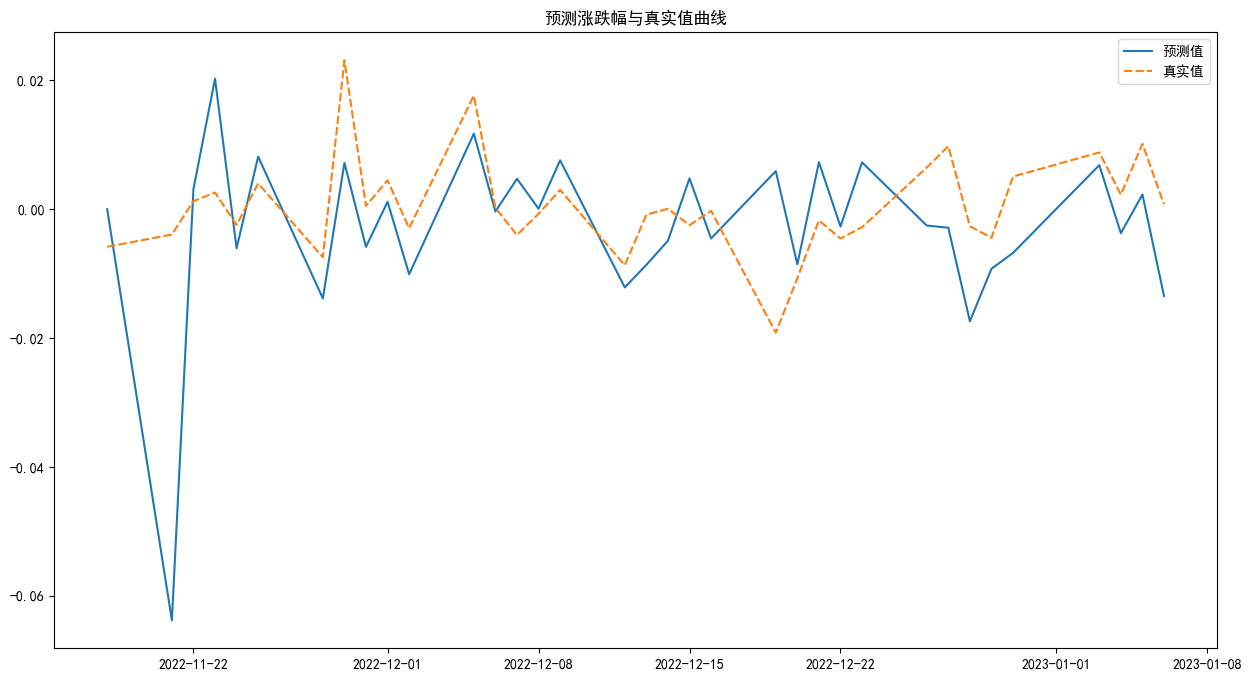

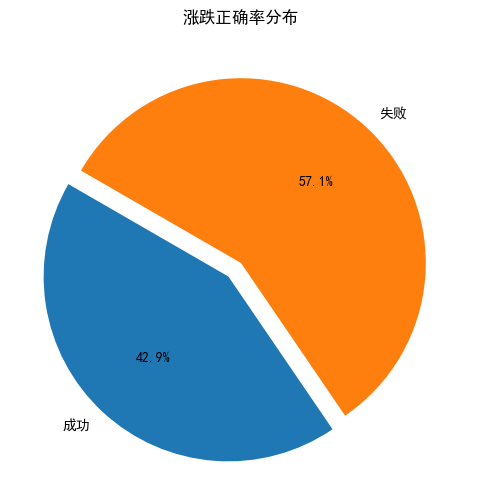

In [1]:
from torch import nn
import torch
import pandas
import numpy
import matplotlib.pyplot as plt
import os
import pickle
import datetime
import time 
import akshare as ak
import seaborn as sns
import matplotlib

matplotlib.use("TkAgg")  # 大小写无所谓 tkaGg ,TkAgg 都行
%matplotlib inline


#plt.rcParams["font.family"] = ["sans-serif"]  # 用来正常显示中文标签
#plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RATIO = 1


class MyData(object):
    def __init__(self, name="上证指数", symbol="sh000001", days4train=30):
        self.name = name
        self.days4train = days4train
        self.symbol = symbol

    def loadData(self):
        print("开始查询数据...")
        start = "20000101"
        today=datetime.date.today()
        today=pandas.to_datetime(today)
        end = f"{today.year}{today.month:0>2}{today.day:0>2}"
        csv_path = os.path.join("../csv", f"{self.name}.csv")

        if os.path.isfile(csv_path):
            df = pandas.read_csv(csv_path, index_col=0, header=0)
            last_date=list(df.date)[-1]
            today_date=f"{today.year}-{today.month:0>2}-{today.day:0>2}"
            if last_date!=today_date:
                df = ak.stock_zh_index_daily_tx(symbol=self.symbol)

        elif "sh" in self.symbol or "sz" in self.symbol:
            df = ak.stock_zh_index_daily_tx(symbol=self.symbol)
        else:
            df = ak.stock_zh_a_hist(
                symbol=self.symbol,
                period="daily",
                start_date=start,
                end_date=end,
                adjust="qfq",
            )
        display(df)
        df.to_csv(csv_path, encoding="utf_8_sig")
        self.df = df

        print("开始分析....")
        data = df["close"]
        data = numpy.array(data, dtype="float32")
        startPoint = data[0]
        oneData = [i * RATIO / startPoint for i in data]  # 将数据净值化
        self.absData = data
        self.data = oneData
        self.oneData = oneData
        xSet, ySet = [], []
        for i in range(len(self.data) - self.days4train):
            xSet.append(self.data[i : i + self.days4train])  # 前days4train来推算后1天的
            ySet.append(self.data[i + self.days4train])
        xSet = numpy.array(xSet, dtype="float32")
        ySet = numpy.array(ySet, dtype="float32")
        self.xSet = xSet
        self.ySet = ySet
        self.startPoint = startPoint

    def trainData(self):
        n = len(self.xSet)
        n = int(n * 0.9)
        trainX = self.xSet[:n]
        trainY = self.ySet[:n]
        # 将数据改变形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
        trainX = trainX.reshape(-1, 1, self.days4train)
        trainY = trainY.reshape(-1, 1, 1)
        # 转为pytorch的tensor对象
        trainX = torch.from_numpy(trainX)
        trainY = torch.from_numpy(trainY)
        if torch.cuda.is_available():
            trainX = trainX.cuda()  # 把数据放到显卡中
            trainY = trainY.cuda()  # 把数据放到显卡中
        self.data = [trainX, trainY]

    def run(self):
        self.loadData()
        self.trainData()


class LSTM(nn.Module):
    """
    使用LSTM进行回归

    参数：
    - input_size: feature size
    - hidden_size: number of hidden units
    - output_size: number of output
    - num_layers: layers of LSTM to stack
    """

    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x


def train(data):
    "训练"
    start = time.time()
    model = LSTM(data.days4train, 8, output_size=1, num_layers=2)
    model.to(DEVICE)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    log = ""
    losses = []
    min_loss = 10086
    for i in range(4000):
        out = model(data.data[0])
        loss = loss_function(out, data.data[1])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if min_loss > loss.item():
            s = "Epoch: {}, Loss:{:.5f}\n".format(i + 1, loss.item())
            log += s
            min_loss = loss.item()
            torch.save(model.state_dict(), "myRnn.pt")
            print(s)
            with open(f"log{data.days4train}.txt", "w+", encoding="utf-8") as f:
                f.write(log)
    plt.plot(losses, "g", label="loss")
    end = time.time()
    print(f"耗时{end-start}s")
    plt.show()


def test(data):
    "测试"
    startPoint = data.startPoint
    if torch.cuda.is_available():  # 如果能用cuda就放到显卡中，否则放cpu中
        rnnDict = torch.load("myRnn.pt")
    else:
        rnnDict = torch.load("myRnn.pt", map_location=torch.device("cpu"))
    model = LSTM(data.days4train, 8, output_size=1, num_layers=2)
    model.load_state_dict(rnnDict)
    model = model.eval()  # 转换成测试模式
    # 注意这里用的是全集 模型的输出长度会比原数据少切片后再作图
    # (seq_size, batch_size, feature_size)
    dataset_x = data.xSet.reshape(-1, 1, data.days4train)
    dataset_x = torch.from_numpy(dataset_x)
    pred_test = model(dataset_x)
    pred_test = pred_test.view(-1).data.numpy()
    minData = min(data.absData)
    maxData = max(data.absData)
    pred_test = [i / RATIO * startPoint for i in pred_test]
    real = data.absData[data.days4train :]
    plt.figure(dpi=300, figsize=(16, 12))
    plt.plot(real, "g", label="真实值")
    plt.plot(pred_test, "r", label="预测值")
    # plt.plot((len(real)*0.7, len(real)*0.7), (minData, maxData), 'g--')
    plt.show()


def pre(data):
    "预测"
    date = list(data.df.date)[-1]
    startPoint = data.startPoint
    if torch.cuda.is_available():
        rnnDict = torch.load("myRnn.pt")
    else:
        rnnDict = torch.load("myRnn.pt", map_location=torch.device("cpu"))
    real = data.absData[data.days4train :]
    dates=[]
    for d in data.df.date:
        if isinstance(d,str):
            d=f"{d[:4]}-{d[4:8]}-{d[8:]}"
        dates.append(d)
    dates = [pandas.to_datetime(d) for d in dates]
    model = LSTM(data.days4train, 8, output_size=1, num_layers=2)
    model.load_state_dict(rnnDict)
    lastDays = data.oneData[-data.days4train :]
    lastDays = numpy.array(lastDays, dtype="float32")
    data.xSet = numpy.append(data.xSet, lastDays)
    dataset_x = data.xSet.reshape(-1, 1, data.days4train)
    dataset_x = torch.from_numpy(dataset_x)
    pred = model(dataset_x)
    pred = pred.view(-1).data.numpy()
    minData = min(data.absData)
    maxData = max(data.absData)

    pred = [i / RATIO * startPoint for i in pred]
    nextDay = pred[-1]
    today = data.absData[-1]

    path = os.getcwd()
    checkPath = '../csv/checkdata.csv'
    if os.path.isfile(checkPath):
        checkData = pandas.read_csv(checkPath)
        checkData={key:list(checkData[key]) for key in checkData.columns[1:]}
    else:
        checkData = {
            "date": [],
            "pre": [],
            "real": [],
            "preRise": [],
            "realRise": [],
            "isRight": [],
        }
    # 存放数据
    check_dates=[pandas.to_datetime(date) for date in checkData["date"]]
    date=pandas.to_datetime(date)
    if date in check_dates:
        i = check_dates.index(date)
        checkData["pre"][i] = nextDay
        checkData["real"][i] = today
    else:
        date=f"{date.year}-{date.month:0>2}-{date.day:0>2}"
        checkData["date"].append(date)
        checkData["pre"].append(nextDay)
        checkData["real"].append(today)
        checkData["preRise"].append(0)
        checkData["realRise"].append(0)
        checkData["isRight"].append(0)
    # 计算是否预测成功    
    for i in range(len(checkData['date'])-1):
        j=i+1
        preRise=checkData["pre"][i]/checkData["real"][i]-1
        realRise=checkData["real"][j]/checkData["real"][i]-1
        checkData["preRise"][j]=preRise
        checkData["realRise"][j]=realRise
        if (preRise>=0 and realRise>=0):
            checkData["isRight"][j]=1
        elif (preRise<0 and realRise<0):
            checkData["isRight"][j]=1
        else:
            checkData["isRight"][j]=0
            
    plt.figure(dpi=300, figsize=(12, 9))
    n = 1000
    d = {"x": dates[-n:], "y": real[-n:]}
    plt.plot("x", "y", "g", data=d, label="真实值")
    next_date = dates[-1] + pandas.Timedelta(days=1)
    d = {"x": dates[-n-1:-1], "y": pred[-n-1:-1]}
    plt.plot("x", "y", "r", data=d, label="预测值")
    plt.legend(loc="best")
    color = "red" if nextDay > today else "green"
    plt.title(
        f"{data.name}基于深度学习的预测曲线\n{date}日预测明日收盘价可能是{nextDay:.2f}",
        color=color,
        fontsize="large",
        fontweight="bold",
    )
    plt.savefig("todayPre.png")
    plt.show()
    return checkData


def showIsright(checkData):
    "显示预测正确与否"
    n=len(checkData['date'])
    for key in checkData:
        checkData[key]=checkData[key][:n]
    df=pandas.DataFrame(checkData)
    display(df)
    df.to_csv('../csv/checkdata.csv',encoding="utf_8_sig")
    data={
        "预测值":checkData["preRise"][:-1],
        "真实值":checkData["realRise"][1:],
    }
    
    df=pandas.DataFrame(data)
    df.index=[pandas.to_datetime(date) for date in checkData['date'][1:]]
    fig = sns.lineplot(data=df)
    fig.get_figure().set_figwidth(15)  # 设置宽度
    fig.get_figure().set_figheight(8)  # 设置高度
    plt.title(f"预测涨跌幅与真实值曲线")
    plt.savefig("check.png")
    plt.show()

        
    labels = ["成功", "失败"]
    right = sum(checkData["isRight"][1:])
    n = len(checkData["isRight"][1:])
    sizes = [right / n, (n - right) / n]
    explode = (0.1, 0)
    plt.pie(
        sizes,
        explode=explode,
        labels=labels,
        autopct="%1.1f%%",
        shadow=False,
        startangle=150,
        normalize=False,
    )
    plt.gcf().set_size_inches(6, 6)
    plt.title("涨跌正确率分布")
    plt.savefig("ratio.png")
    plt.show()


if __name__ == "__main__":
    data = MyData(name="上证指数", days4train=30)
    data.run()
    # train(data)
    # test(data)
    checkData = pre(data)
    showIsright(checkData)
    
    


In [2]:
import akshare as ak


def new_func():
    start = "20000101"
    localTime = time.localtime()
    end = f"{localTime[0]}{localTime[1]:0>2}{localTime[2]:0>2}"
    df = ak.stock_zh_a_hist(
        symbol="000999", period="daily", start_date=start, end_date=end, adjust="qfq"
    )
    return df


df = new_func()
df


日期     开盘     收盘     最高     最低     成交量           成交额      振幅  \
0     2000-03-09  12.78  14.33  15.52  12.78  554364  1.368844e+09  220.97   
1     2000-03-10  13.88  12.47  13.90  12.37  192228  4.580979e+08   10.68   
2     2000-03-13  12.31  11.93  12.32  11.69   69843  1.554156e+08    5.05   
3     2000-03-14  11.69  11.85  12.28  10.36   84776  1.812409e+08   16.09   
4     2000-03-15  11.51  11.44  12.16  11.36   35902  7.898122e+07    6.75   
...          ...    ...    ...    ...    ...     ...           ...     ...   
5263  2023-01-03  47.25  49.11  49.53  46.96  166873  8.142611e+08    5.49   
5264  2023-01-04  49.08  49.56  50.20  48.62   90532  4.472303e+08    3.22   
5265  2023-01-05  49.56  49.22  50.28  49.07   97897  4.855411e+08    2.44   
5266  2023-01-06  48.75  47.15  48.97  46.80  146395  6.967130e+08    4.41   
5267  2023-01-09  47.30  47.90  48.09  46.95   11481  5.465900e+07    2.42   

          涨跌幅    涨跌额    换手率  
0     1055.65  13.09  69.30  
1      -12.98  -1.86  24.03  
2       -4.33  -0.54   8.73  
3       -0.67  -0.08  10.60  
4       -3.46  -0.41   4.49  
...       ...    ...    ...  
5263     4.91   2.30   1.71  
5264     0.92   0.45   0.93  
5265    -0.69  -0.34   1.00  
5266    -4.21  -2.07   1.50  
5267     1.59   0.75   0.12  

[5268 rows x 11 columns]